# Определение стоимости автомобилей

**О проекте:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.  

**Задача:** Построить модель для определения стоимости.

**О данных:** Исторические данные: технические характеристики, комплектации и цены автомобилей.

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Подготовка данных

Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

In [69]:
data = pd.read_csv('/datasets/autos.csv')

In [70]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [71]:
data.columns = data.columns.str.lower()
data = data.rename(columns = {'datecrawled':'date_crawled',
                      'vehicletype':'vehicle_type',
                      'registrationyear':'registration_year',
                      'fueltype':'fuel_type',
                      'datecreated':'date_created',
                      'numberofpictures':'number_of_pictures',
                      'postalcode':'postal_code',
                      'lastseen':'last_seen',
                             'registrationmonth':'registration_month'})
data.columns 

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [72]:
data.shape

(354369, 16)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [74]:
data.postal_code = data.postal_code.astype('str')

In [75]:
data['date_crawled']

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354364    2016-03-21 09:50:58
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: date_crawled, Length: 354369, dtype: object

In [76]:
to_d_type = ['date_crawled', 'date_created', 'last_seen']
for date in to_d_type:
    data[date] = pd.to_datetime(data[date], format = '%Y-%m-%d  %H:%M:%S')

In [77]:
#удалим 4 дубликата
data = data.drop_duplicates()

### Обработка пропусков

#### vehicle_type пропуски

In [78]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропуски мы будем восстанавливать по моделям, а не по брендам автомобилей, поскольку бренд, как правило, выпускает модели различных типов автомобилей и выбор модального может искажать данные

In [79]:
vehicle_type_keys = data.pivot_table(index=['model'] ,values = 'vehicle_type',  aggfunc=lambda x: x.mode()).reset_index()
vehicle_type_d = dict(vehicle_type_keys.values)
vehicle_type_d

{'100': 'sedan',
 '145': 'small',
 '147': 'sedan',
 '156': 'wagon',
 '159': 'wagon',
 '1_reihe': 'small',
 '1er': 'sedan',
 '200': 'sedan',
 '2_reihe': 'small',
 '300c': 'wagon',
 '3_reihe': 'sedan',
 '3er': 'sedan',
 '4_reihe': 'wagon',
 '500': 'small',
 '5_reihe': 'bus',
 '5er': 'sedan',
 '601': 'sedan',
 '6_reihe': 'wagon',
 '6er': 'coupe',
 '7er': 'sedan',
 '80': 'sedan',
 '850': 'wagon',
 '90': 'sedan',
 '900': 'convertible',
 '9000': 'sedan',
 '911': 'coupe',
 'a1': 'small',
 'a2': 'small',
 'a3': 'sedan',
 'a4': 'wagon',
 'a5': 'coupe',
 'a6': 'wagon',
 'a8': 'sedan',
 'a_klasse': 'sedan',
 'accord': 'sedan',
 'agila': 'small',
 'alhambra': 'bus',
 'almera': 'sedan',
 'altea': 'bus',
 'amarok': 'suv',
 'antara': 'suv',
 'arosa': 'small',
 'astra': 'sedan',
 'auris': 'sedan',
 'avensis': 'wagon',
 'aveo': 'small',
 'aygo': 'small',
 'b_klasse': 'bus',
 'b_max': 'bus',
 'beetle': 'sedan',
 'berlingo': 'bus',
 'bora': 'sedan',
 'boxster': 'convertible',
 'bravo': 'sedan',
 'c1': 's

In [80]:
#replace values in col2 based on dictionary values in col1
data.loc[data['vehicle_type'].isna(), 'vehicle_type'] = data.loc[data['vehicle_type'].isna(),\
                                                                 'vehicle_type'].fillna(data['model'].map(vehicle_type_d),\
                                                                                     inplace = True)

In [81]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [82]:
data = data.dropna(subset = ['vehicle_type'], axis = 0)

#### gearbox пропуски

In [83]:
gearbox_keys = data.pivot_table(index=['model'] ,values = 'gearbox',  aggfunc=lambda x: x.mode()).reset_index()
gearbox_keys_d = dict(gearbox_keys.values)
gearbox_keys_d

{'100': 'manual',
 '145': 'manual',
 '147': 'manual',
 '156': 'manual',
 '159': 'manual',
 '1_reihe': 'manual',
 '1er': 'manual',
 '200': 'manual',
 '2_reihe': 'manual',
 '300c': 'auto',
 '3_reihe': 'manual',
 '3er': 'manual',
 '4_reihe': 'manual',
 '500': 'manual',
 '5_reihe': 'manual',
 '5er': 'auto',
 '601': 'manual',
 '6_reihe': 'manual',
 '6er': 'auto',
 '7er': 'auto',
 '80': 'manual',
 '850': 'manual',
 '90': 'manual',
 '900': 'manual',
 '9000': 'manual',
 '911': 'manual',
 'a1': 'manual',
 'a2': 'manual',
 'a3': 'manual',
 'a4': 'manual',
 'a5': 'manual',
 'a6': 'auto',
 'a8': 'auto',
 'a_klasse': 'manual',
 'accord': 'manual',
 'agila': 'manual',
 'alhambra': 'manual',
 'almera': 'manual',
 'altea': 'manual',
 'amarok': 'manual',
 'antara': 'manual',
 'arosa': 'manual',
 'astra': 'manual',
 'auris': 'manual',
 'avensis': 'manual',
 'aveo': 'manual',
 'aygo': 'manual',
 'b_klasse': 'manual',
 'b_max': 'manual',
 'beetle': 'manual',
 'berlingo': 'manual',
 'bora': 'manual',
 'box

In [84]:
data.loc[data['gearbox'].isna(), 'gearbox'] = data.loc[data['gearbox'].isna(),\
                                                                 'gearbox'].fillna(data['model'].map(gearbox_keys_d),\
                                                                                     inplace = True)

In [85]:
data = data.dropna(subset=['gearbox'])

#### model пропуски

Пропуски по моделям удаляем, поскольку это критично важный для нас признак. Восстановить его наиболее достоверно не представляется возможным по тем данным, которые мы имеем.

In [86]:
data['model'] = data['model'].fillna('unknown')

<ipython-input-86-b373227bdce6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model'] = data['model'].fillna('unknown')


#### fuel_type пропуски

In [87]:
fuel = data.pivot_table(index=['model'], values = 'fuel_type', aggfunc=lambda x: x.mode()).reset_index()
fuel_d = dict(fuel.values)
fuel_d

{'100': 'petrol',
 '145': 'petrol',
 '147': 'petrol',
 '156': 'petrol',
 '159': 'gasoline',
 '1_reihe': 'petrol',
 '1er': 'petrol',
 '200': 'petrol',
 '2_reihe': 'petrol',
 '300c': 'gasoline',
 '3_reihe': 'petrol',
 '3er': 'petrol',
 '4_reihe': 'gasoline',
 '500': 'petrol',
 '5_reihe': 'gasoline',
 '5er': 'gasoline',
 '601': 'petrol',
 '6_reihe': 'petrol',
 '6er': 'petrol',
 '7er': 'petrol',
 '80': 'petrol',
 '850': 'petrol',
 '90': 'petrol',
 '900': 'petrol',
 '9000': 'petrol',
 '911': 'petrol',
 'a1': 'petrol',
 'a2': 'petrol',
 'a3': 'petrol',
 'a4': 'gasoline',
 'a5': 'gasoline',
 'a6': 'gasoline',
 'a8': 'petrol',
 'a_klasse': 'petrol',
 'accord': 'petrol',
 'agila': 'petrol',
 'alhambra': 'gasoline',
 'almera': 'petrol',
 'altea': 'gasoline',
 'amarok': 'gasoline',
 'antara': 'gasoline',
 'arosa': 'petrol',
 'astra': 'petrol',
 'auris': 'petrol',
 'avensis': 'petrol',
 'aveo': 'petrol',
 'aygo': 'petrol',
 'b_klasse': 'petrol',
 'b_max': 'petrol',
 'beetle': 'petrol',
 'berlingo'

In [88]:
data.loc[data['fuel_type'].isna(), 'fuel_type'] = data.loc[data['fuel_type'].isna(),\
                                                                 'fuel_type'].fillna(data['model'].map(fuel_d),\
                                                                                     inplace = True)

In [89]:
data = data.dropna(subset=['fuel_type'])

### repaired пропуски

<Axes: xlabel='repaired', ylabel='price'>

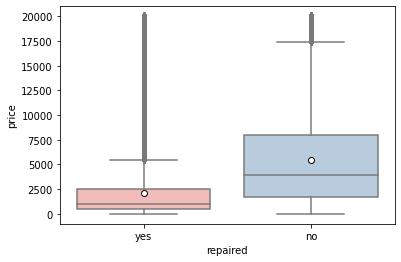

In [90]:
sns.boxplot(x = 'repaired',
            y = 'price',
            data = data,
            showmeans = True,
            meanprops = {"marker":'o',
                        "markerfacecolor":'white',
                        "markeredgecolor":'black'},
            palette = 'Pastel1')

In [91]:
median_price_per_model = dict(data.pivot_table(index=['model'], values = 'price', aggfunc='median').reset_index().values)
median_price_per_model

{'100': 1200.0,
 '145': 750.0,
 '147': 2050.0,
 '156': 1300.0,
 '159': 6499.5,
 '1_reihe': 990.0,
 '1er': 9250.0,
 '200': 3500.0,
 '2_reihe': 2590.0,
 '300c': 9850.0,
 '3_reihe': 2000.0,
 '3er': 3700.0,
 '4_reihe': 2800.0,
 '500': 7690.0,
 '5_reihe': 6500.0,
 '5er': 5499.0,
 '601': 1399.0,
 '6_reihe': 2498.0,
 '6er': 14200.0,
 '7er': 5600.0,
 '80': 990.0,
 '850': 965.0,
 '90': 1400.0,
 '900': 1625.0,
 '9000': 2799.0,
 '911': 15895.0,
 'a1': 13990.0,
 'a2': 3800.0,
 'a3': 5690.0,
 'a4': 4800.0,
 'a5': 16500.0,
 'a6': 5600.0,
 'a8': 8145.0,
 'a_klasse': 2350.0,
 'accord': 3700.0,
 'agila': 1500.0,
 'alhambra': 3700.0,
 'almera': 1400.0,
 'altea': 5500.0,
 'amarok': 15120.0,
 'antara': 9150.0,
 'arosa': 999.0,
 'astra': 1999.0,
 'auris': 7950.0,
 'avensis': 4850.0,
 'aveo': 4250.0,
 'aygo': 3999.0,
 'b_klasse': 8500.0,
 'b_max': 12675.0,
 'beetle': 5300.0,
 'berlingo': 2350.0,
 'bora': 2390.0,
 'boxster': 13900.0,
 'bravo': 2999.5,
 'c1': 3599.5,
 'c2': 2500.0,
 'c3': 3290.0,
 'c4': 5500.

In [92]:
data['median_price_per_model'] = data['model'].map(median_price_per_model)
data['median_price_per_model']

1         1900.0
2         5800.0
3         2800.0
4         3500.0
5         3700.0
           ...  
354362    6099.0
354363    3200.0
354366    3300.0
354367    5800.0
354368    2800.0
Name: median_price_per_model, Length: 293561, dtype: float64

In [93]:
data['repaired'] = np.where((data.repaired.isna())&(data.price<data['median_price_per_model']), 'yes', 'no')

Видим, что машины, которые не были в ремонте дороже тех, которые в ремонте были

In [94]:
missing_repaired_ind = data[data.repaired.isna()].index

In [95]:
data

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,median_price_per_model
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,no,2016-03-24,0,66954,2016-04-07 01:46:50,1900.0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46,5800.0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2800.0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,3500.0
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,no,2016-04-04,0,33775,2016-04-06 19:17:07,3700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,no,2016-03-19,0,96465,2016-03-19 20:44:43,6099.0
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29 10:17:23,3200.0
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,3300.0
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,5800.0


### Удаление переменных

<Axes: xlabel='number_of_pictures', ylabel='price'>

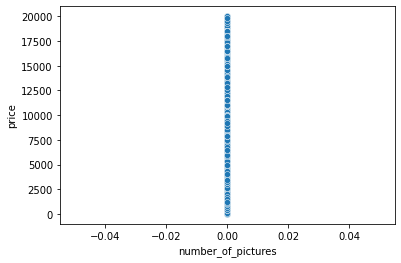

In [96]:
sns.scatterplot(data = data,
                x = 'number_of_pictures',
                y = 'price')

Для моделирования мне не понадобятся переменные date_crawled, date_created, last_seen, registration_month, postal_code - они мало информативны + median_price_per_model (я создавала ее для создания другой переменной, теперь могу удалить ее)

Количество фото не имеет ни одного заполненного поля. Скорее всего произошла какая-то ошибка при выгрузке, удалим эту переменную.

In [97]:
df = data.copy()

In [98]:
df = df.drop(columns = ['date_crawled', 'last_seen', 'number_of_pictures',\
              'registration_month', 'postal_code', \
              'median_price_per_model', 'date_created'])
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,no
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,no


In [ ]:
df.duplicated().sum()

### Подозрительные значения

Посмотрим на описательную статистику 

In [99]:
df.describe()

,price,registration_year,power,kilometer
count,293561.000000,293561.000000,293561.000000,293561.000000
mean,4811.888292,2002.438042,117.596360,128192.522167
std,4633.650693,6.418146,176.185971,36935.198823
min,0.000000,1910.000000,0.000000,5000.000000
25%,1299.000000,1999.000000,75.000000,125000.000000
50%,3100.000000,2003.000000,109.000000,150000.000000
75%,6990.000000,2007.000000,147.000000,150000.000000
max,20000.000000,2018.000000,20000.000000,150000.000000


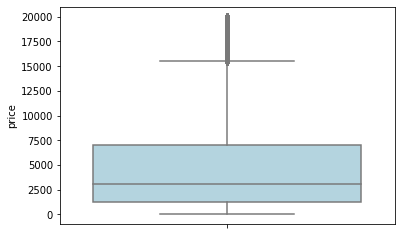

In [100]:
#по цене аномальные значения не наблюдаются
sns.boxplot(y = df['price'], color = 'lightblue');

Выгрузка данных происходила в 2016, значит, те данные, где год регистрации автомобиля более 2016 должны быть удалены. Также первый автомобиль появился в 1806 году, поэтому автомобили с датой регистрации ранее, чем в 1806 году будут удалены

In [101]:
df = df[(df['registration_year']<=2016)&(df['registration_year']>=1806)]

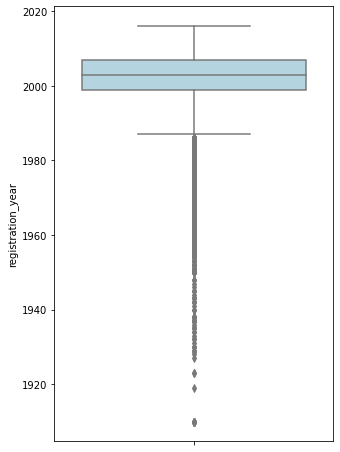

In [102]:
#год регистраци
plt.figure(figsize = (5,8))
sns.boxplot(y = df['registration_year'], color = 'lightblue');

In [103]:
print((df['registration_year']<=1999).sum())
print((df['registration_year']<=1990).sum())
print((df['registration_year']<=1985).sum())
print((df['registration_year']<=1980).sum())
print((df['registration_year']<=1960).sum())

87616
9053
4331
2689
248


Если наше приложение ориентировано на среднестатистического посетителя сайта по продаже автомобилей, а не коллекционера редких/старых экземпляров, то стоит приблизить распределение года регистрации к тому, которое будет интересовать потенциальног клиента. Предположим, что в 2016 году человек выбирает себе автомобиль для того, чтобы на нем ездить и не часто его чинить. Получается, его будут интересовать автомобили, зарегистрированные максимум 20 лет назад (и то кажется, что это много), поэтому ограничим наш датасет 1990 годом регистрации (если ограничивать его 1999 (Q1), то мы теряем 100 000 наблюдений, что крайне нежелательно)

In [104]:
df = df[df['registration_year']>=1990]
df.shape

(286184, 10)

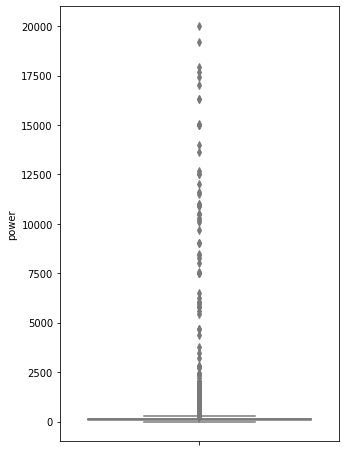

In [105]:
#лошадиные силы
plt.figure(figsize = (5,8))
sns.boxplot(y = df['power'], color = 'lightblue');

In [106]:
(df['power']>=400).sum()

603

In [107]:
df = df[df['power']<=400]

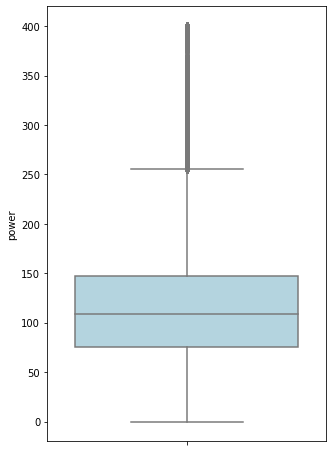

In [108]:
#лошадиные силы
plt.figure(figsize = (5,8))
sns.boxplot(y = df['power'], color = 'lightblue');

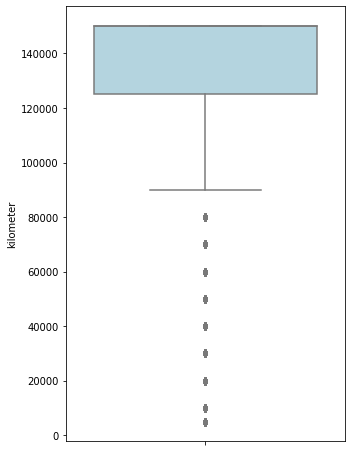

In [109]:
#пробег
plt.figure(figsize = (5,8))
sns.boxplot(y = df['kilometer'], color = 'lightblue');


In [110]:
(df['kilometer']<80000).sum()/df.shape[0]

0.11853262658161372

Выбросы по переменной пробега решено было не удалять, поскольку их доля значительна. Если итоговая модель получится неудовлетворительной, мы сможем вернуться к этой переменной и попробовать почистить ее от выбросов

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285626 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              285626 non-null  int64 
 1   vehicle_type       285626 non-null  object
 2   registration_year  285626 non-null  int64 
 3   gearbox            285626 non-null  object
 4   power              285626 non-null  int64 
 5   model              285626 non-null  object
 6   kilometer          285626 non-null  int64 
 7   fuel_type          285626 non-null  object
 8   brand              285626 non-null  object
 9   repaired           285626 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.0+ MB


<Axes: xlabel='repaired', ylabel='count'>

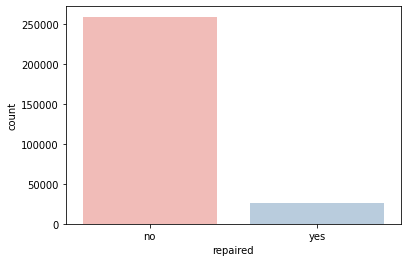

In [112]:
sns.countplot(x = 'repaired', data = df, palette = 'Pastel1')

<Axes: xlabel='gearbox', ylabel='count'>

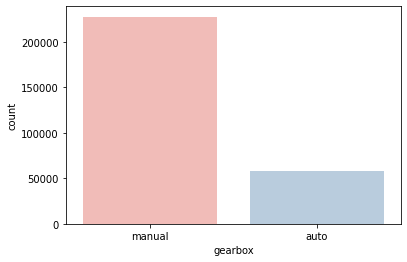

In [113]:
sns.countplot(x = 'gearbox', data = df, palette = 'Pastel1')

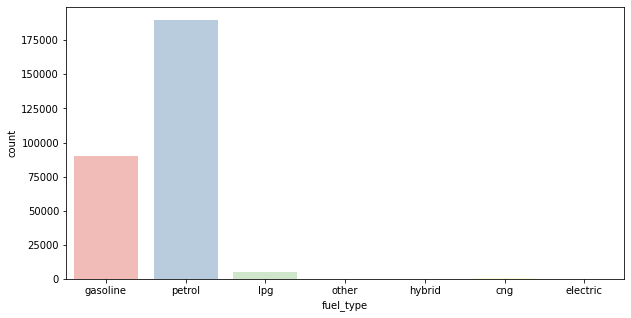

In [114]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'fuel_type', data = df, palette = 'Pastel1');

In [115]:
df['fuel_type'].value_counts()

petrol      189831
gasoline     90113
lpg           4809
cng            501
hybrid         213
other           84
electric        75
Name: fuel_type, dtype: int64

In [116]:
#заменим мало наполненные категории на 'other'
df['fuel_type'] = df['fuel_type'].replace(['lpg', 'cng', 'hybrid', 'electric'], 'other')

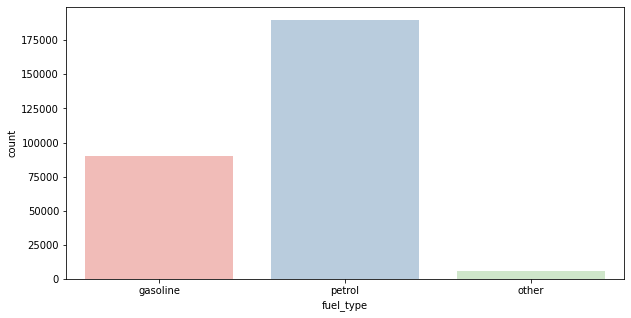

In [117]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'fuel_type', data = df, palette = 'Pastel1');

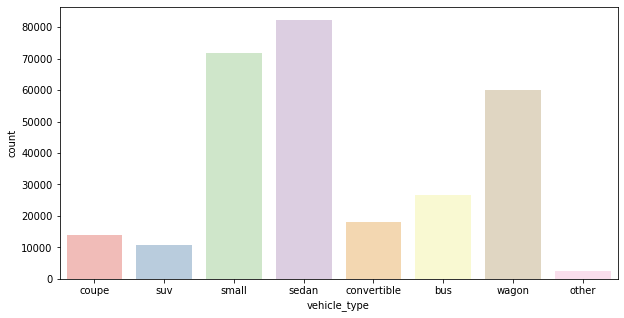

In [118]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'vehicle_type', data = df, palette = 'Pastel1');

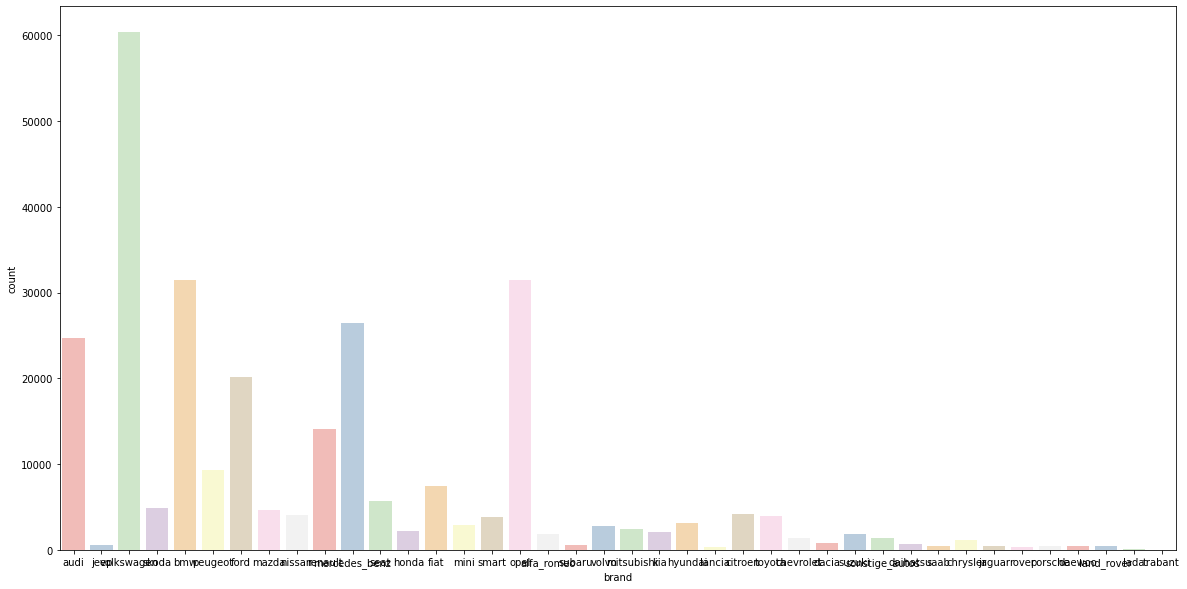

In [119]:
plt.figure(figsize = (20,10))
sns.countplot(x = 'brand', data = df, palette = 'Pastel1');

In [120]:
print(len(df['brand'].unique()))
df['brand'].value_counts().tail()

40


jaguar     421
rover      357
lancia     346
lada       146
trabant     36
Name: brand, dtype: int64

In [121]:
print(len(df['model'].unique()))
df['model'].value_counts().tail(30)

248


range_rover_sport     53
nubira                50
911                   44
lybra                 43
move                  43
90                    39
v60                   39
croma                 35
lodgy                 34
145                   34
terios                33
kaefer                26
b_max                 24
delta                 22
9000                  22
601                   21
musa                  20
materia               18
charade               15
amarok                15
q3                    14
kappa                 13
gl                    12
samara                 7
elefantino             7
kalina                 6
i3                     6
rangerover             3
200                    3
range_rover_evoque     2
Name: model, dtype: int64

## Обучение моделей

In [123]:
for feature in df.columns: # цикл по всем колонкас
    if df[feature].dtype == 'object': # применять только к object столбцам
        df[feature] = pd.Categorical(df[feature]).codes # строки меняем на целые

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285626 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              285626 non-null  int64
 1   vehicle_type       285626 non-null  int8 
 2   registration_year  285626 non-null  int64
 3   gearbox            285626 non-null  int8 
 4   power              285626 non-null  int64
 5   model              285626 non-null  int16
 6   kilometer          285626 non-null  int64
 7   fuel_type          285626 non-null  int8 
 8   brand              285626 non-null  int8 
 9   repaired           285626 non-null  int8 
dtypes: int16(1), int64(4), int8(5)
memory usage: 12.8 MB


In [125]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop('price', axis=1), df.price, test_size=0.4, random_state=12345) 

In [126]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345) 

In [127]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(171375, 9)
(171375,)
(57125, 9)
(57125,)
(57126, 9)
(57126,)


### CatBoost

In [128]:
df.isnull().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [129]:
cat_features = ['vehicle_type', 'gearbox', 'model','fuel_type',
                'brand', 'repaired']

In [130]:
%%time
rf = CatBoostRegressor(cat_features = ['vehicle_type', 'gearbox', 'model','fuel_type',
                'brand', 'repaired'], eval_metric="RMSE", learning_rate=0.05, iterations=1000, verbose=100
)
rf.fit(features_train, target_train, plot=True, eval_set=(features_valid, target_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4457.7365019	test: 4458.9672215	best: 4458.9672215 (0)	total: 200ms	remaining: 3m 20s
100:	learn: 1836.7980377	test: 1845.7139168	best: 1845.7139168 (100)	total: 16.6s	remaining: 2m 27s
200:	learn: 1747.1850147	test: 1762.5350004	best: 1762.5350004 (200)	total: 32s	remaining: 2m 7s
300:	learn: 1701.5472019	test: 1722.6245290	best: 1722.6245290 (300)	total: 50.7s	remaining: 1m 57s
400:	learn: 1674.1322739	test: 1699.2225316	best: 1699.2225316 (400)	total: 1m 6s	remaining: 1m 38s
500:	learn: 1655.5459541	test: 1684.3657267	best: 1684.3657267 (500)	total: 1m 21s	remaining: 1m 20s
600:	learn: 1640.5167178	test: 1672.3464139	best: 1672.3464139 (600)	total: 1m 36s	remaining: 1m 4s
700:	learn: 1627.8901943	test: 1663.2732233	best: 1663.2732233 (700)	total: 1m 52s	remaining: 47.8s
800:	learn: 1616.4652718	test: 1655.5702494	best: 1655.5702494 (800)	total: 2m 10s	remaining: 32.4s
900:	learn: 1606.1263303	test: 1648.5960715	best: 1648.5960715 (900)	total: 2m 26s	remaining: 16.1s
999:	l

In [131]:
%%time
pred_rf = rf.predict(features_test)

CPU times: user 517 ms, sys: 21.9 ms, total: 539 ms
Wall time: 330 ms


In [132]:
np.sqrt(mean_squared_error(target_test,pred_rf))

1641.1660569521412

Text(0.5, 0, 'CatBoost Feature Importance')

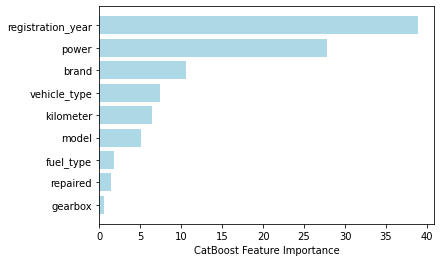

In [133]:
sorted_feature_importance = rf.feature_importances_.argsort()
plt.barh(features_train.columns[sorted_feature_importance], 
        rf.feature_importances_[sorted_feature_importance], 
        color='lightblue')
plt.xlabel("CatBoost Feature Importance")

### Lightgbm

In [169]:
param_grid = {'learning_rate': [0.05,0.08],
              'n_estimators': [1000,2000],
              'max_depth': [5, 10]}

In [170]:
estimator = lightgbm.LGBMRegressor(objective='regression', random_state=12345)

In [171]:
%%time
model = GridSearchCV(estimator=estimator, 
                     param_grid=param_grid,
                     cv=3,
                     n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')
model.fit(features_train, target_train)

CPU times: user 29 s, sys: 662 ms, total: 29.7 s
Wall time: 6min 12s


GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression',
                                     random_state=12345),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.08], 'max_depth': [5, 10],
                         'n_estimators': [1000, 2000]},
             scoring='neg_root_mean_squared_error')

In [174]:
best_params = model.best_estimator_
print(best_params)

LGBMRegressor(learning_rate=0.08, max_depth=10, n_estimators=2000,
              objective='regression', random_state=12345)


In [175]:
features = features_train.columns
importance_values = model.best_estimator_.feature_importances_

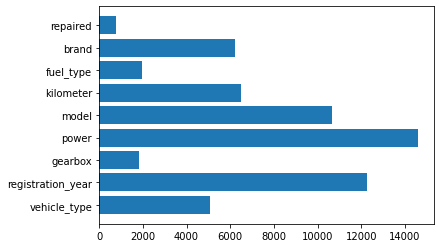

In [176]:
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()

In [179]:
%%time 
#отдельно запустим только лучшую модель, чтобы оценить время обучения
model_gbm = LGBMRegressor(learning_rate=0.08, max_depth=10, n_estimators=2000,
              objective='regression', random_state=12345)
model_gbm.fit(features_train, target_train)

CPU times: user 30.6 s, sys: 284 ms, total: 30.8 s
Wall time: 19.2 s


LGBMRegressor(learning_rate=0.08, max_depth=10, n_estimators=2000,
              objective='regression', random_state=12345)

In [178]:
%%time
pred = best_params.predict(features_valid)
pred_test = best_params.predict(features_test)
print('RMSE valid:',mean_squared_error(target_valid, pred, squared=False))
print('RMSE test:',mean_squared_error(target_test, pred_test, squared=False))

RMSE valid: 1574.586350578679
RMSE test: 1574.156847261214
CPU times: user 24.9 s, sys: 35.3 ms, total: 24.9 s
Wall time: 14.3 s


### RandomForestRegressor

In [180]:
forest=RandomForestRegressor(random_state=12345)

In [181]:
%%time 
forest = RandomForestRegressor(n_estimators = 1000, max_depth = 16, min_samples_leaf = 10, random_state = 12345) 
forest.fit(features_train, target_train)

CPU times: user 5min 54s, sys: 1.13 s, total: 5min 55s
Wall time: 6min 4s


RandomForestRegressor(max_depth=16, min_samples_leaf=10, n_estimators=1000,
                      random_state=12345)

In [182]:
%%time
pred_v = forest.predict(features_valid)
pred_t = forest.predict(features_test)
print('RMSE valid:',mean_squared_error(target_valid, pred_v, squared=False))
print('RMSE test:',mean_squared_error(target_test, pred_t, squared=False))

RMSE valid: 1695.4106496510565
RMSE test: 1693.7856623944544
CPU times: user 22.3 s, sys: 33.7 ms, total: 22.3 s
Wall time: 23.9 s


При увеличении количества независимых деревьев, улучшение качества леса не произошло.

## Анализ моделей

Модель 1 - CatBoost
- время обучения 4 мин 21 сек
- время предсказания 330 ms
- RMSE на тестовой выборке: 1641.17

Модель 2 - LightGBM
- время обучения 30.6 сек
- время предсказания 14.3 секунды
- RMSE на тестовой выборке: 1574.16

Модель 3 - RandomForestRegressor

- время обучения 6 мин 4 сек
- время предсказания 23.9 сек
- RMSE на тестовой выборке: 1693.79

## Вывод
- На очищенных от пропусков, выбросов, аномалий и дубликатов данных были построены 3 моделей для предсказания цены автомобиля по его характеристикам (числовым и категориальным). Модели: CatBoost, LightGBM и RandomForestRegressor
- Наилучшей моделью для предсказания цены автомобиля выбрана модель LightGBM. Модель получена при помощи перебора гиперпараметров в GridsearchCV. Модель выбрана как наилучшая по соотношению времени работы и полученного результата. Данная модель прогнозирует цену сошибкой около 1574 евро.
- Также моделью были выделены наиболее важные для прогнозирования цены переменные. ТОП-3 таких переменных: мощность автомобиля в лошадиных силах, год регистрации автомобиля и его модель.